<a href="https://colab.research.google.com/github/Neelu2647/Mini-project/blob/maithili_branch/Chest_X_Ray_Images_(Pneumonia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Setting up Kaggle API

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
#Downloading the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:32<00:00, 217MB/s]
100% 2.29G/2.29G [00:32<00:00, 76.3MB/s]


In [3]:
#Unzipping the dataset
import zipfile

zip_data = zipfile.ZipFile('/content/chest-xray-pneumonia.zip')
zip_data.extractall('/content/')
zip_data.close()

# Importing Libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

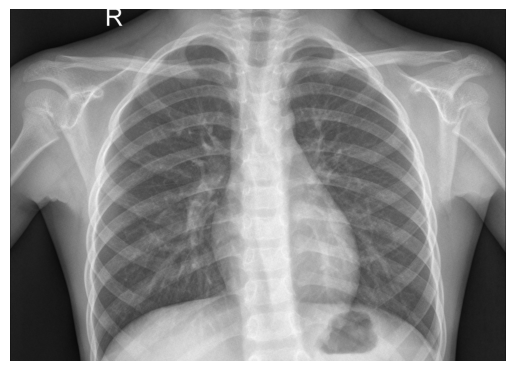

In [5]:
# Read the image using OpenCV
img = cv2.imread('/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

# Convert BGR to RGB (Matplotlib expects RGB format)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()

In [6]:
img.shape

(1317, 1857, 3)

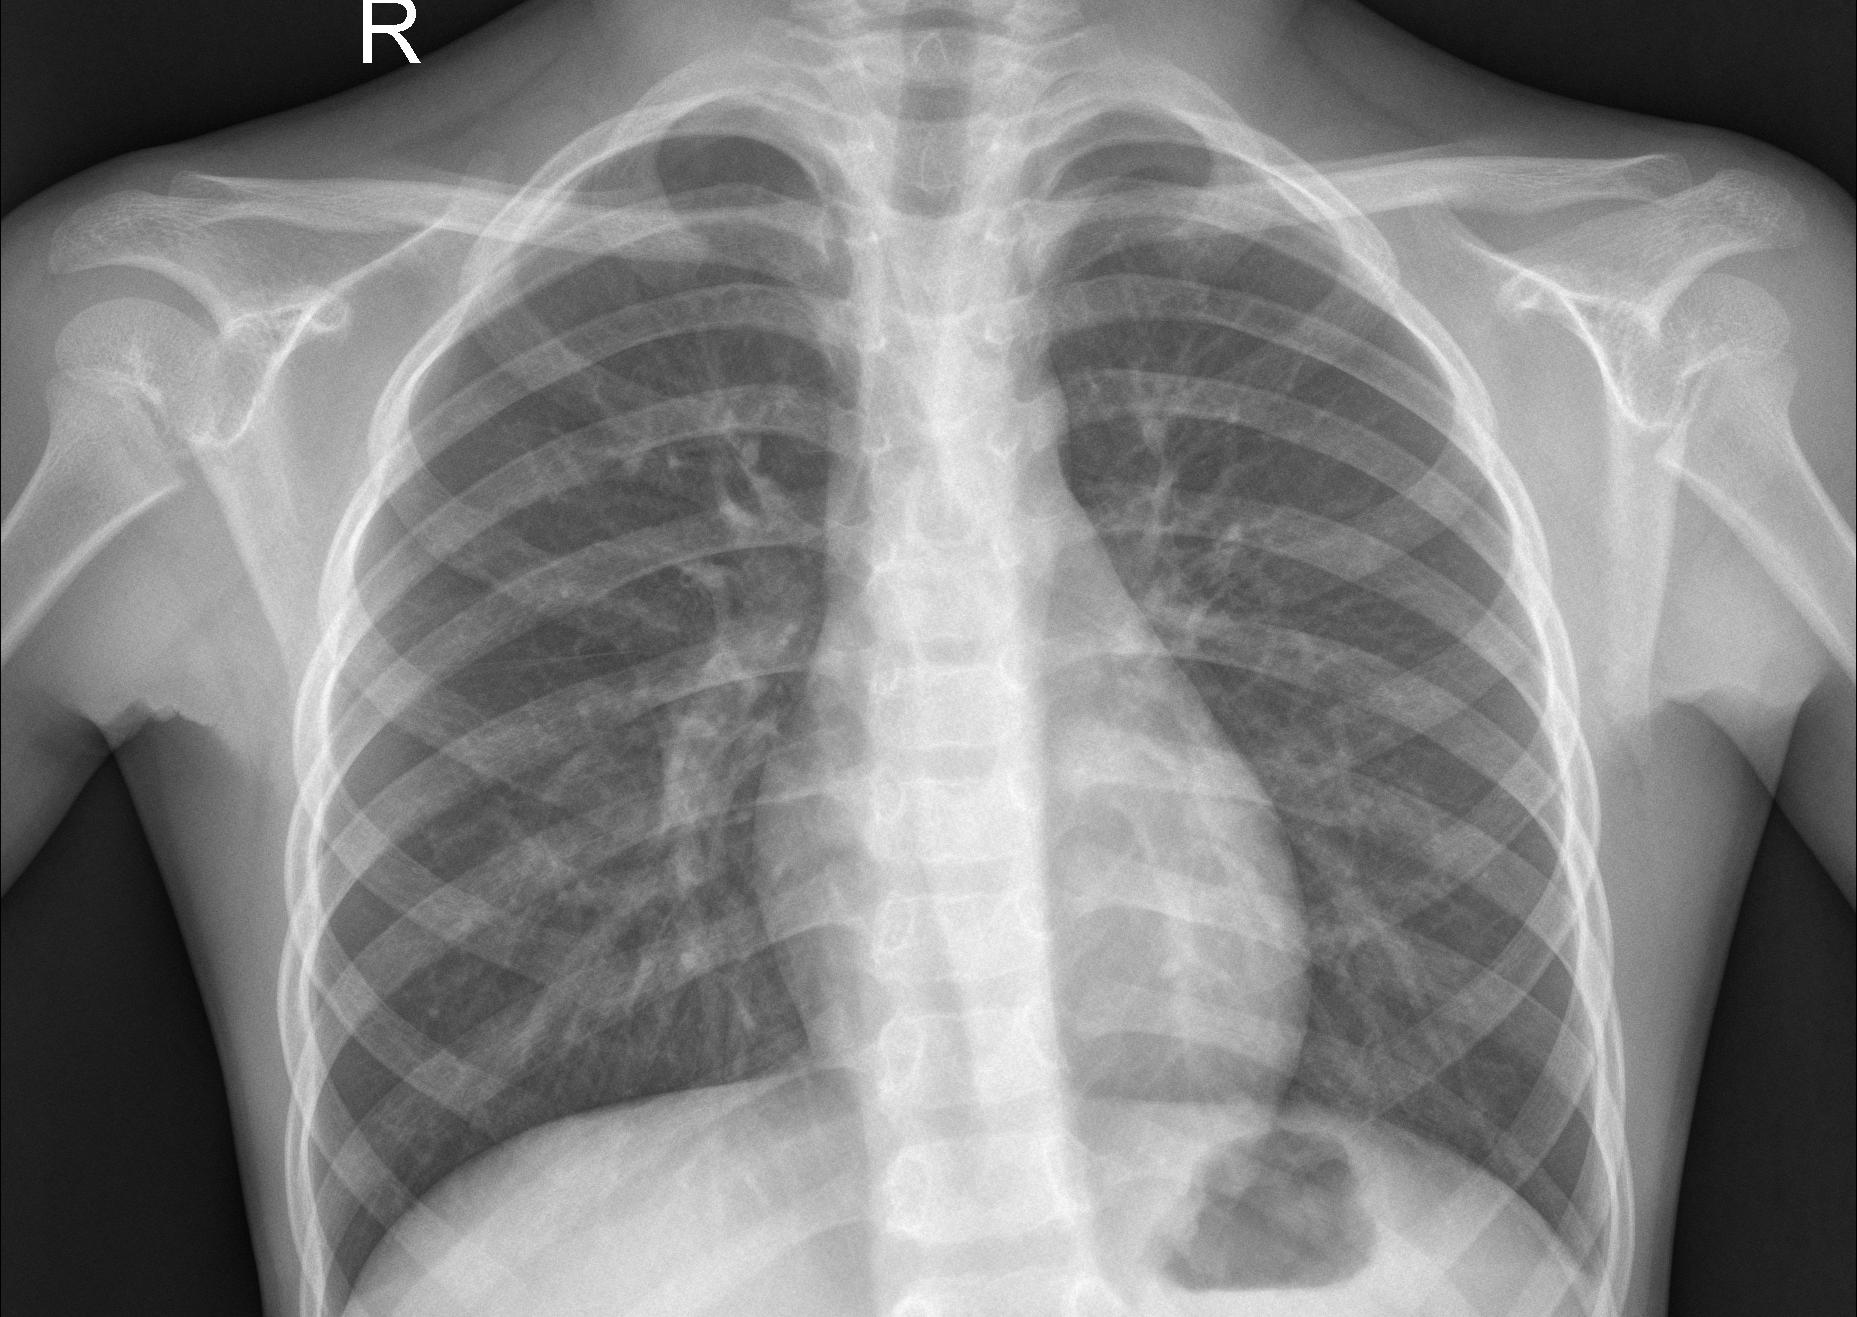

In [7]:
# trying an alternative

import PIL
from PIL import Image
image = Image.open('/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg')
image

# Exploratory Data Analysis (EDA)

In [8]:
dataset_path = "/content/chest_xray"
categories = ["train", "test", "val"]

for category in categories:
    class_path = os.path.join(dataset_path, category)
    print(f"\n --> {category.upper()} Set:")
    for class_name in os.listdir(class_path):
        class_folder = os.path.join(class_path, class_name)
        print(f"  - {class_name}: {len(os.listdir(class_folder))} images")


 --> TRAIN Set:
  - NORMAL: 1341 images
  - PNEUMONIA: 3875 images

 --> TEST Set:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images

 --> VAL Set:
  - NORMAL: 8 images
  - PNEUMONIA: 8 images


--------------------------------------------------------------------------------

## **According to the above statistics,**

**Info about dataset balancing:**
1. The TRAIN set is imbalanced with a PNEUMONIA:NORMAL ratio of 2.89:1.
2. The TEST set is quite balanced with a PNEUMONIA:NORMAL ratio of 1.67:1
3. The VAL set is perfectly balanced with a PNEUMONIA:NORMAL ratio of 1:1.

**Info about data splitting:**

Current Split is:
- TRAIN: ~88.7%
- TEST: ~11.3%
- VAL: ~0.3% (very low)
--------------------------------------------------------------------------------

<ipython-input-9-445c1dcbee4a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")


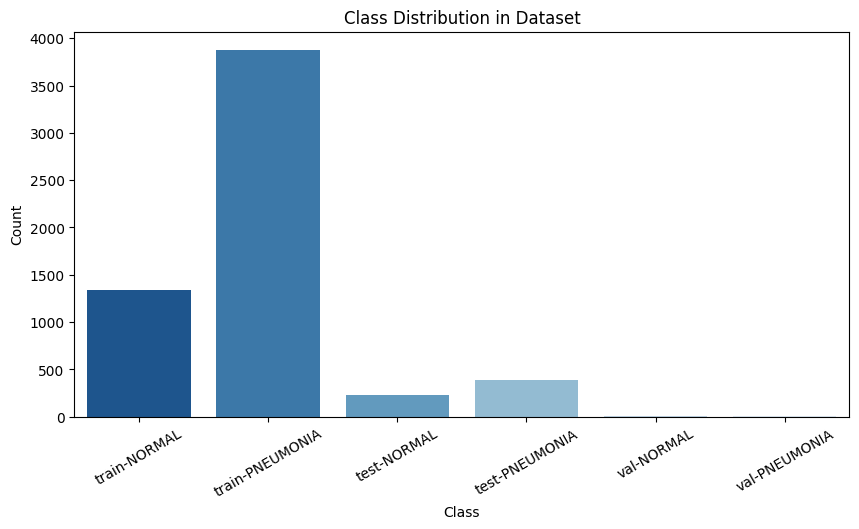

In [9]:
# Count images per class
class_counts = {"Class": [], "Count": []}
for category in ["train", "test", "val"]:
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(dataset_path, category, class_name)
        class_counts["Class"].append(f"{category}-{class_name}")
        class_counts["Count"].append(len(os.listdir(class_path)))

df = pd.DataFrame(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")
plt.xticks(rotation=30)
plt.title("Class Distribution in Dataset")
plt.show()

# Balancing the TRAIN:TEST set using data augmentation

In [10]:
normal_train_dir = "/content/chest_xray/train/NORMAL"
augmented_dir = "/content/chest_xray/train/NORMAL_AUGMENTED"

# Create directory to save augmented images
os.makedirs(augmented_dir, exist_ok=True)

# Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load all NORMAL images
normal_images = [f for f in os.listdir(normal_train_dir) if f.endswith(".jpeg")]

# Augment images to reach target count
num_augmented = 0
target_augmented = 1242  # Number of additional images needed calculated by 3875/1.5 = 2583 => 2583-1341 = 1242

for img_name in normal_images:
    if num_augmented >= target_augmented:
        break

    img_path = os.path.join(normal_train_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)

    # Generate augmented images
    aug_iter = datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix="aug", save_format="jpeg")

    for i in range(1):
        next(aug_iter)
        num_augmented += 1
        if num_augmented >= target_augmented:
            break

print(f"Successfully generated {num_augmented} augmented images in {augmented_dir}!")

Successfully generated 1242 augmented images in /content/chest_xray/train/NORMAL_AUGMENTED!


In [11]:
for img_name in os.listdir(augmented_dir):
    src = os.path.join(augmented_dir, img_name)
    dst = os.path.join(normal_train_dir, img_name)
    shutil.move(src, dst)

print("Augmented images added to NORMAL training set!")

Augmented images added to NORMAL training set!


<ipython-input-12-445c1dcbee4a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")


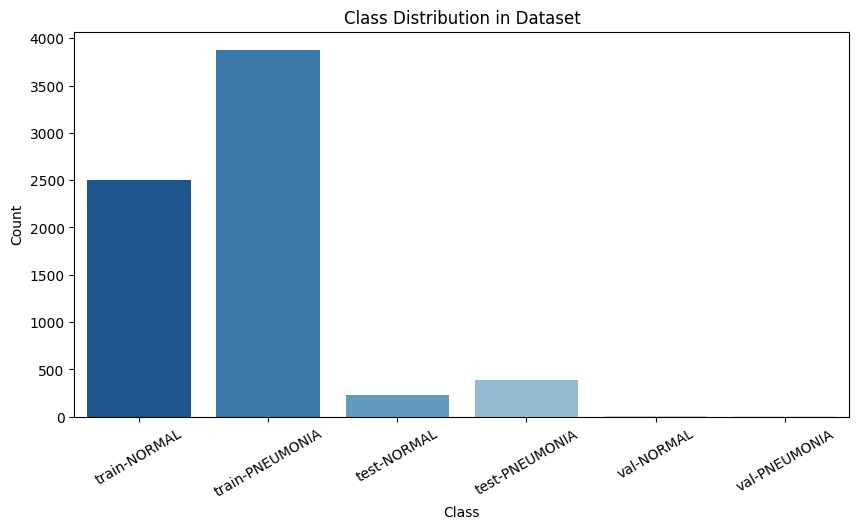

In [12]:
# Count images per class
class_counts = {"Class": [], "Count": []}
for category in ["train", "test", "val"]:
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(dataset_path, category, class_name)
        class_counts["Class"].append(f"{category}-{class_name}")
        class_counts["Count"].append(len(os.listdir(class_path)))

df = pd.DataFrame(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")
plt.xticks(rotation=30)
plt.title("Class Distribution in Dataset")
plt.show()

# Increasing the number of images in the VAL set to be around ~10%

In [13]:
normal_val_dir = "/content/chest_xray/val/NORMAL"
augmented_normal_val_dir = "/content/chest_xray/val/NORMAL_AUGMENTED"

pneumonia_val_dir = "/content/chest_xray/val/PNEUMONIA"
augmented_pneumonia_val_dir = "/content/chest_xray/val/PNEUMONIA_AUGMENTED"

os.makedirs(augmented_normal_val_dir, exist_ok=True)
os.makedirs(augmented_pneumonia_val_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

normal_images = [f for f in os.listdir(normal_val_dir) if f.endswith(".jpeg")]
pneumonia_images = [f for f in os.listdir(pneumonia_val_dir) if f.endswith(".jpeg")]

target_augmented_NORMAL = 250
target_augmented_PNEUMONIA = 380

def augment_images(image_list, input_dir, output_dir, target_count):
    num_augmented = 0
    num_originals = len(image_list)

    while num_augmented < target_count:
        for img_name in image_list:
            if num_augmented >= target_count:
                break  # Stop if target reached

            img_path = os.path.join(input_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, axis=0)

            # Generate multiple images per original
            aug_iter = datagen.flow(img, batch_size=1, save_to_dir=output_dir,
                                    save_prefix="aug", save_format="jpeg")

            for _ in range(target_count // num_originals + 1):  # Ensure we generate enough images
                next(aug_iter)
                num_augmented += 1
                if num_augmented >= target_count:
                    break

    print(f"Successfully generated {num_augmented} augmented images in {output_dir}!")

# **Augment NORMAL images**
augment_images(normal_images, normal_val_dir, augmented_normal_val_dir, target_augmented_NORMAL)

# **Augment PNEUMONIA images**
augment_images(pneumonia_images, pneumonia_val_dir, augmented_pneumonia_val_dir, target_augmented_PNEUMONIA)


Successfully generated 250 augmented images in /content/chest_xray/val/NORMAL_AUGMENTED!
Successfully generated 380 augmented images in /content/chest_xray/val/PNEUMONIA_AUGMENTED!


In [14]:
augmented_normal_val_dir = "/content/chest_xray/val/NORMAL_AUGMENTED"
augmented_pneumonia_val_dir = "/content/chest_xray/val/PNEUMONIA_AUGMENTED"

normal_train_dir = "/content/chest_xray/val/NORMAL"
pneumonia_train_dir = "/content/chest_xray/val/PNEUMONIA"

for img_name in os.listdir(augmented_normal_val_dir):
    src = os.path.join(augmented_normal_val_dir, img_name)
    dst = os.path.join(normal_train_dir, img_name)
    shutil.move(src, dst)

print(f"Successfully moved augmented NORMAL images to {normal_train_dir}!")

for img_name in os.listdir(augmented_pneumonia_val_dir):
    src = os.path.join(augmented_pneumonia_val_dir, img_name)
    dst = os.path.join(pneumonia_train_dir, img_name)
    shutil.move(src, dst)

print(f"Successfully moved augmented PNEUMONIA images to {pneumonia_train_dir}!")

Successfully moved augmented NORMAL images to /content/chest_xray/val/NORMAL!
Successfully moved augmented PNEUMONIA images to /content/chest_xray/val/PNEUMONIA!


<ipython-input-15-445c1dcbee4a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")


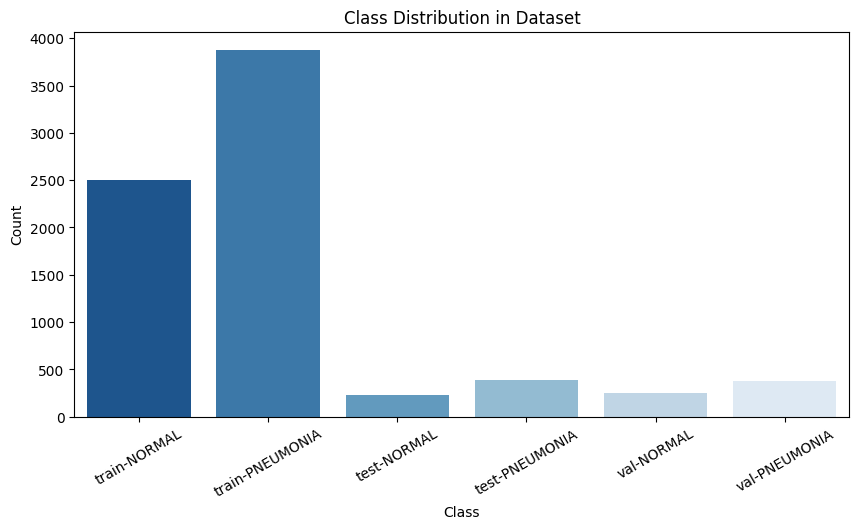

In [15]:
# Count images per class
class_counts = {"Class": [], "Count": []}
for category in ["train", "test", "val"]:
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(dataset_path, category, class_name)
        class_counts["Class"].append(f"{category}-{class_name}")
        class_counts["Count"].append(len(os.listdir(class_path)))

df = pd.DataFrame(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")
plt.xticks(rotation=30)
plt.title("Class Distribution in Dataset")
plt.show()

In [16]:
dataset_path = "/content/chest_xray"
categories = ["train", "test", "val"]

for category in categories:
    class_path = os.path.join(dataset_path, category)
    print(f"\n --> {category.upper()} Set:")
    for class_name in os.listdir(class_path):
        class_folder = os.path.join(class_path, class_name)
        print(f"  - {class_name}: {len(os.listdir(class_folder))} images")


 --> TRAIN Set:
  - NORMAL: 2502 images
  - NORMAL_AUGMENTED: 0 images
  - PNEUMONIA: 3875 images

 --> TEST Set:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images

 --> VAL Set:
  - PNEUMONIA_AUGMENTED: 0 images
  - NORMAL: 253 images
  - NORMAL_AUGMENTED: 0 images
  - PNEUMONIA: 381 images


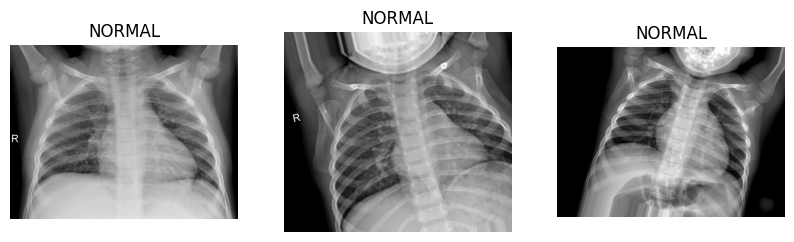

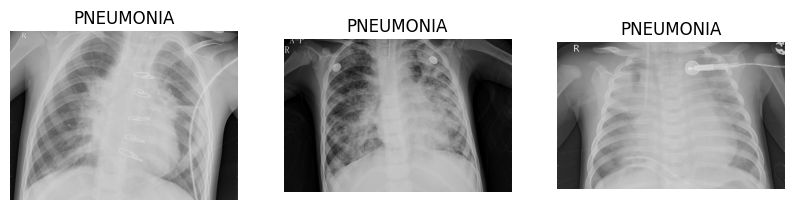

In [24]:
import random

def show_sample_images(category, num_samples=3):
    class_path = os.path.join(dataset_path, "train", category)
    images = random.sample(os.listdir(class_path), num_samples)

    plt.figure(figsize=(10, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb, cmap='gray')
        plt.title(category)
        plt.axis("off")

    plt.show()

show_sample_images("NORMAL")
show_sample_images("PNEUMONIA")

-----------------------------------------------
## **Some Observations:**

- The images are sharp and clear, with visible anatomical structures. This is good for diagnostic purposes.

- The normal cases have clear lung fields, while the pneumonia cases exhibit hazy opacities or white patches, indicating fluid or inflammation. These differences are noticeable.

- While the images are distinguishable, some pneumonia cases seem slightly darker, which could make finer details harder to distinguish. Adjusting brightness and contrast might enhance the visibility of the patterns.
-----------------------------------------------

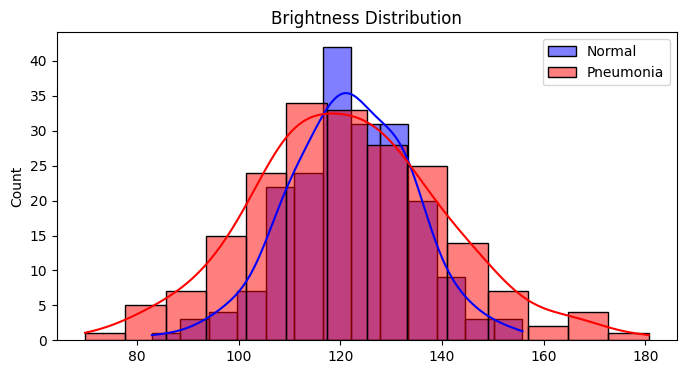

In [19]:
import numpy as np

def calculate_brightness(img):
    return np.mean(img)

brightness_values = {"NORMAL": [], "PNEUMONIA": []}

for category in ["NORMAL", "PNEUMONIA"]:
    class_path = os.path.join(dataset_path, "train", category)
    for img_name in os.listdir(class_path)[:200]:  # Sample 200 images
        img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
        brightness_values[category].append(calculate_brightness(img))

# Plot brightness distribution
plt.figure(figsize=(8, 4))
sns.histplot(brightness_values["NORMAL"], color="blue", label="Normal", kde=True)
sns.histplot(brightness_values["PNEUMONIA"], color="red", label="Pneumonia", kde=True)
plt.legend()
plt.title("Brightness Distribution")
plt.show()

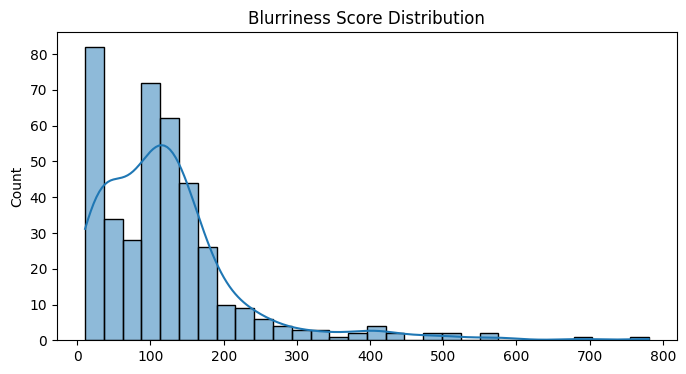

In [20]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

blurriness_scores = []
for category in ["NORMAL", "PNEUMONIA"]:
    class_path = os.path.join(dataset_path, "train", category)
    for img_name in os.listdir(class_path)[:200]:
        img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
        blurriness_scores.append(variance_of_laplacian(img))

plt.figure(figsize=(8, 4))
sns.histplot(blurriness_scores, bins=30, kde=True)
plt.title("Blurriness Score Distribution")
plt.show()

In [21]:
import numpy as np

img_shapes = []
for category in ["NORMAL", "PNEUMONIA"]:
    class_path = os.path.join(dataset_path, "train", category)
    for img_name in os.listdir(class_path)[:200]:  # Sample 200 images
        img = cv2.imread(os.path.join(class_path, img_name))
        img_shapes.append(img.shape)

img_shapes = np.array(img_shapes)
print("Unique Image Shapes:", np.unique(img_shapes, axis=0))

Unique Image Shapes: [[ 127  384    3]
 [ 191  486    3]
 [ 209  482    3]
 ...
 [2283 2120    3]
 [2374 2427    3]
 [2534 2890    3]]


-----------------------------------------------
##### All images are of different shapes. Thus, resizing is required.
-----------------------------------------------

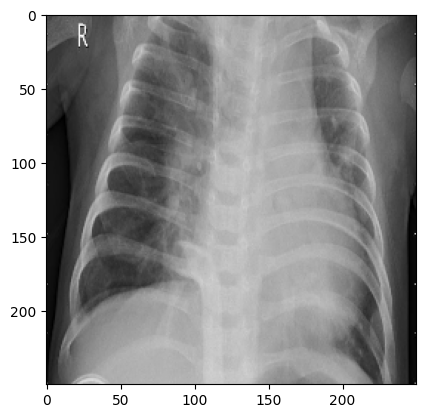

In [22]:
#Resizing

resized = cv2.resize(img, (250,250))
resized.shape
plt.imshow(resized)

In [23]:
# Normalizing the pixel Values

normalized = resized / 255.0
normalized

array([[[0.28627451, 0.28627451, 0.28627451],
        [0.34509804, 0.34509804, 0.34509804],
        [0.32156863, 0.32156863, 0.32156863],
        ...,
        [0.17647059, 0.17647059, 0.17647059],
        [0.16862745, 0.16862745, 0.16862745],
        [0.15686275, 0.15686275, 0.15686275]],

       [[0.31764706, 0.31764706, 0.31764706],
        [0.31372549, 0.31372549, 0.31372549],
        [0.28627451, 0.28627451, 0.28627451],
        ...,
        [0.17647059, 0.17647059, 0.17647059],
        [0.17647059, 0.17647059, 0.17647059],
        [0.16078431, 0.16078431, 0.16078431]],

       [[0.31372549, 0.31372549, 0.31372549],
        [0.30980392, 0.30980392, 0.30980392],
        [0.25490196, 0.25490196, 0.25490196],
        ...,
        [0.17254902, 0.17254902, 0.17254902],
        [0.17647059, 0.17647059, 0.17647059],
        [0.17254902, 0.17254902, 0.17254902]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.09019608, 0.09019608, 0.09019608],
        [0.1254902 , 0

In [26]:
#standarizing the images

mean = np.mean(normalized)
std = np.std(normalized)

standardized = (normalized - mean) / std

print("Mean after standardization:", np.mean(standardized))
print("Std after standardization:", np.std(standardized))

Mean after standardization: -1.0186340659856796e-16
Std after standardization: 0.9999999999999998
